# Raster Analytics - Calculating wildfire landslide Risk

This project is based off of https://github.com/Esri/arcgis-python-api/blob/master/samples/04_gis_analysts_data_scientists/calculate_post_fire_landslide_risk.ipynb for learning purposes. 

In October 2017, wildfires raged through Sonoma and Napa counties, devastating surrounding communities. In the wake of these fires, the burn scars could cause further risk to public safety from a different kind of disaster: landslides. Post-fire landslides are particularly hazardous because there is more erosion and weaker soil in burned areas without vegetation to anchor the topsoil.

Groups handling rehabilitation, emergency planning and mitigation after a wildfire need to assess the vulnerability of the landscape to landslides. In this notebook, we will provide local emergency management teams a summary of post-wildfire landslide risk, so officials can target mitigation efforts to the most vulnerable watershed basins.

We will use the imagery layers to assess landslide risk per watershed within the burn area. We will create a landslide risk map and then summarize the landslide risk based on watershed sub-basins. We will use raster function chains to derive a burn severity map, a topographic slope map, and a landcover index map. These individual processing chains will be combined into one processing chain for distributed processing on the Raster Analytics server and then be summarized by watershed sub-basins.

##### Import required Libraries

In [17]:
import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import *
from ipywidgets import *

import arcpy
from arcpy.ia import *
from arcpy import env
from arcpy.sa import *

In [18]:
gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')
arcgis.raster.analytics.is_supported(gis)

True

# Get data
For this analysis we need the following datasets

  - Landsat 8 imagery for before (Before_L8)-
  - Landast 8 imagery for after (After_L8) the wildfire
  - DEM (digital elevation model) showing the elevation of the terrain
  - NLCD (National Landcover Dataset) showing land use and predominant vegetation type
  - watershed basin dataset
In the cells below, we access these datasets from the GIS

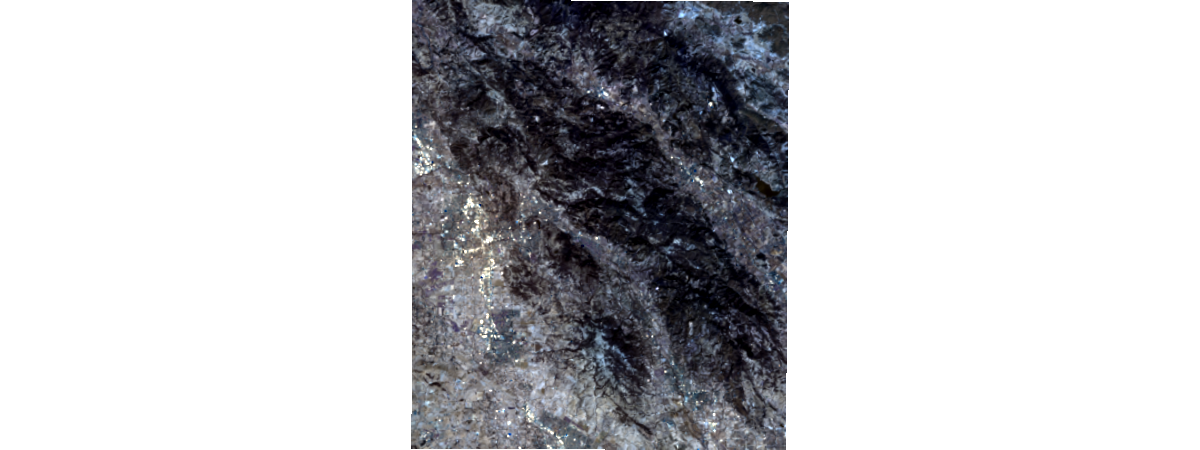

In [19]:
before_l8 = gis.content.search('title:Before_L8 owner:api_data_owner',
                               item_type = "Image Service",
                               outside_org=True)[0].layers[0]
after_l8 = gis.content.search('title:After_L8 owner:api_data_owner',
                              item_type = "Image Service",
                              outside_org=True)[0].layers[0]

before_l8

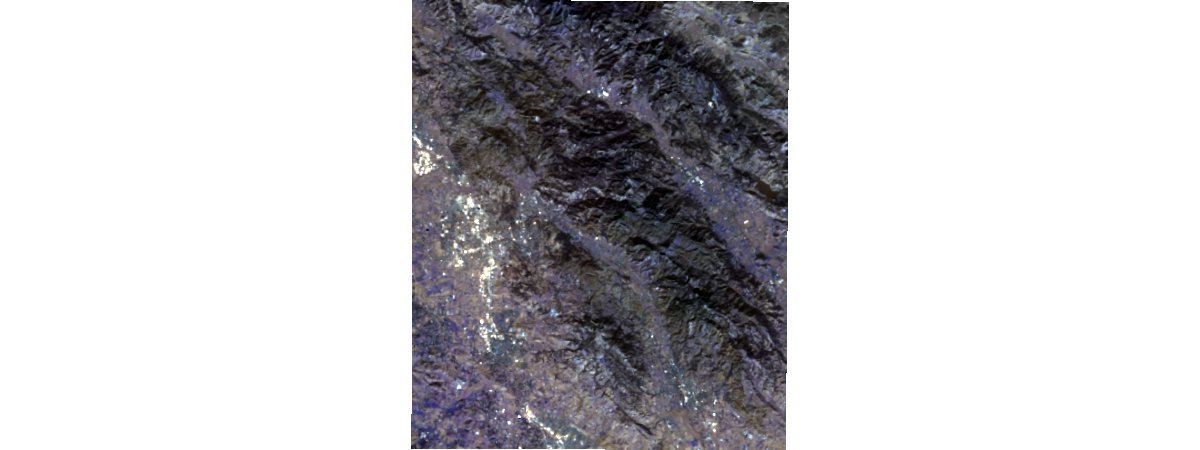

In [47]:
after_l8

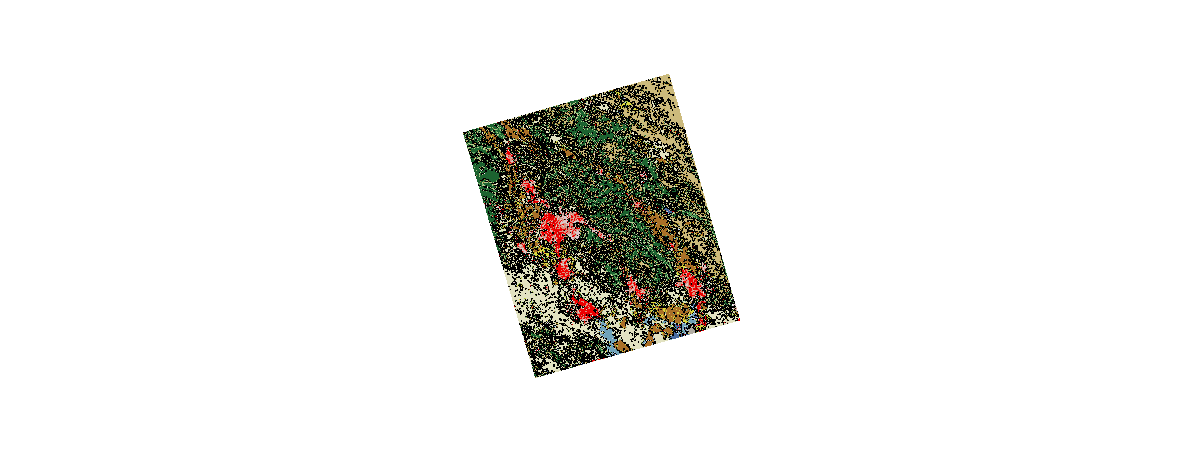

In [20]:
dem = gis.content.search('title:Sonoma_DEM owner:api_data_owner',
                         item_type = "Image Service",
                         outside_org=True)[0].layers[0]
nlcd = gis.content.search('title:Sonoma_NLCD2011 owner:api_data_owner',
                          item_type = "Image Service",
                          outside_org=True)[0].layers[0]
basins = gis.content.search('title:Sonoma_Basins owner:api_data_owner',
                            item_type = "Image Service",
                            outside_org=True)[0].layers[0]

# A preview of National Landcover Dataset layer
nlcd

# Create a burn severity map
To compare the burn scars on the before and after Landsat imagery, we’ll choose the multispectral bands 5,3,2 to be displayed. The [5,3,2] band combination improves visibility of fire and burn scars. Healthy vegetation is shown in bright red, while stressed vegetation is displayed as dull red. Nonvegetated features such as bare and urban areas are displayed in various shades of gray and blue.

Below, we apply the same bands combination to the before_l8 and after_l8 layers.

In [21]:
infrared_before = extract_band(before_l8,
    band_names = ['sr_band5','sr_band3','sr_band2'])
infrared_after = extract_band(after_l8,
    band_names = ['sr_band5','sr_band3','sr_band2'])

# Visual Assessment
Below, in order to visually compare the burn effects, we create two maps and load the extracted bands of before and after imagery.

In [22]:
# Create two maps to compare before and after imageries side by side
map1 = gis.map(location='-122.58, 38.45', zoomlevel=10)
map2 = gis.map(location='-122.58, 38.45', zoomlevel=10)
map1.layout = Layout(flex='1 1', height='500px', padding='10px')
map2.layout = Layout(flex='1 1', height='500px', padding='10px')
map1.add_layer(infrared_before)
map2.add_layer(infrared_after)
box = HBox([map1, map2])
box

From the maps above, we are able to visually observe the burn scars. Next, let us repeat this process, but this time, we will try to quantify the extent of forest fire.

## Quantitative Assessment
A Normalized Burn Ratio (NBR) can be used to delineate the burned areas and identify the severity of the fire. The formula for NBR is very similar to that of NDVI except that it uses near-infrared band 5 and the short-wave infrared band 7:

NBR = (b5 - B7) / (B5 + B7)
 
The NBR equation was designed to be calculated from reflectance, but it can be calculated from radiance and digital_number (dn) with changes to the burn severity (discussed in the table below). For a given area, an NBR is calculated from an image just prior to the burn and a second NBR is calculated for an image immediately following the burn. Burn extent and severity is evaluated by taking the difference between these two index layers:

NBR = NBR(prefire) - NBR(posttfire)

The meaning of the ∆NBR values can vary by scene, and interpretation in specific instances should always be based on some field assessment. However, the following table from the USGS FireMon program can be useful as a first approximation for interpreting the NBR difference:

-2.0 to 0.1  = Regrowth and unburned
0.1 to 0.27 = Low severity burn
0.27 to 0.44 = medium severity burn
0.44 to 0.66 = moderate severity burn
'> 0.66       = High severity burn

Source: http://wiki.landscapetoolbox.org/doku.php/remote_sensing_methods:normalized_burn_ratio

In [57]:
# Calculate before/after NBR indices and their difference
nbr_prefire  = band_arithmetic(before_l8,
                               band_indexes = "(b5 - b7) / (b5 + b7)")
nbr_postfire = band_arithmetic(after_l8,
                               band_indexes = "(b5 - b7) / (b5 + b7)")

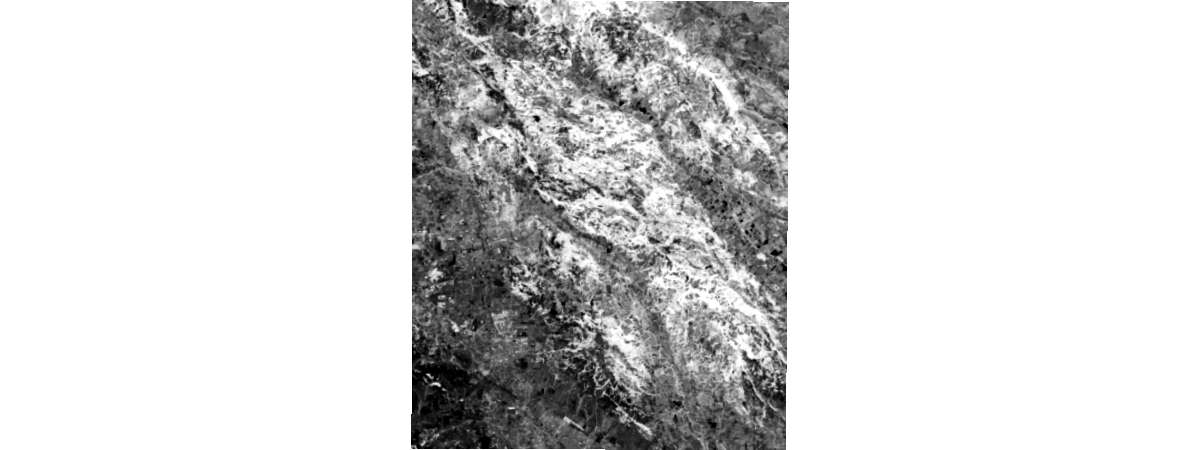

In [59]:
nbr_prefire

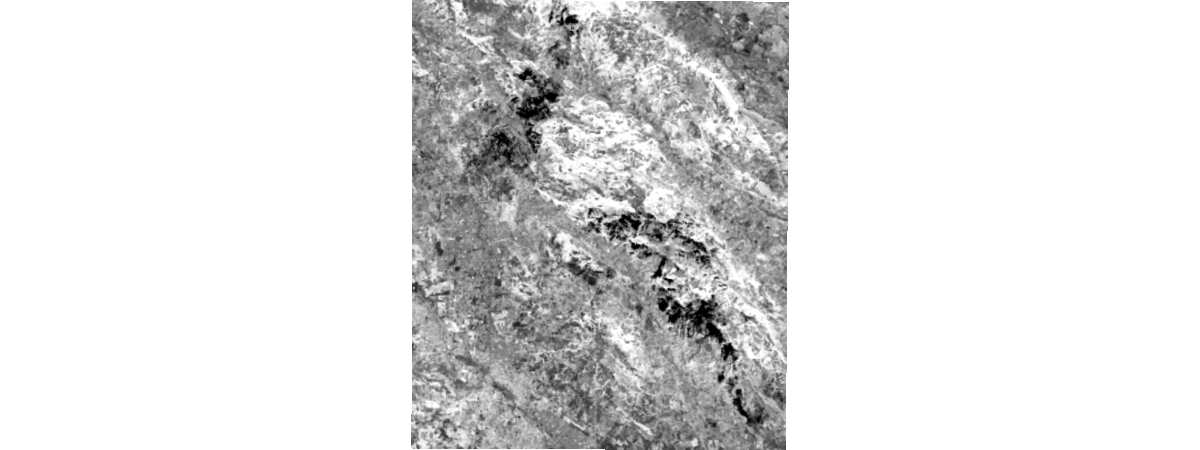

In [60]:
nbr_postfire

In [72]:
nbr_prefire = arcpy.sa.Raster("nbr_prefire")
nbr_postfire = arcpy.sa.Raster("nbr_postfire")
# nbr pre and post fire are both functioning, but nbr diff is not. This is causing nbr_diff_remap not to work and then my
# burn_severity colormap not to work
nbr_diff = nbr_prefire - nbr_postfire

In [73]:
nbr_diff

Exception: Invalid or missing input parameters.
Operation on file C:\users\arcgis\Local Settings\Application Data\ESRI\Local Caches\MapCacheV1\pythonapi.playground.esri.com_server_services_after_l8_tif_imageserver?token=cyfbdunrvebwjeup-qjnlfm8cigy1sr0bhhn4jxp2fb2wjbz2utbkfwf3fgpsbm-psf1fpppfmupsy6lr-phr_qq1fufuylap2qzhnnumz-xi1hik1qm6u5s2kpw6nxuxcaecfizs1r2oyq1y3m3iv42kz3mitpjs2yqthh7ut0. failed. Unknown error.
(Error Code: 400)

<ImageryLayer url:"https://pythonapi.playground.esri.com/server/rest/services/Before_L8/ImageServer">

In [24]:
# Use Remap function to reclassify the NBR difference score to 1-5
nbr_diff_remap = remap(nbr_diff,
                       input_ranges=[-2.0,  0.1,  # Regrowth and Unburned
                                     0.1, 0.27,   # Low Severity burn
                                     0.27, 0.44,  # Medium Severity burn
                                     0.44, 0.66,  # Moderate Severity
                                     0.66, 2.00], # High Severity
                       output_values=[1, 2, 3, 4, 5], 
                       astype='u8')

In [51]:
remap(nbr_diff,
                       input_ranges=[-2.0,  0.1,  # Regrowth and Unburned
                                     0.1, 0.27,   # Low Severity burn
                                     0.27, 0.44,  # Medium Severity burn
                                     0.44, 0.66,  # Moderate Severity
                                     0.66, 2.00], # High Severity
                       output_values=[1, 2, 3, 4, 5])

Exception: Unable to complete operation.
Operation on file C:\users\arcgis\Local Settings\Application Data\ESRI\Local Caches\MapCacheV1\pythonapi.playground.esri.com_server_services_after_l8_tif_imageserver?token=31ktespp9sedczsaokjmqvxp-ss3rtljzw7tq6upi0fxxiwqh_tj9ahmz6zemvrqs_vz5t7gwnzecowxx1uu-fzbzzjwmfiukqnqetxz2t4u0vdvzb_4ojikviocvptkeov2vr3jzt_fydhjqkmnzxklhxls4eak9t5li97hcqe. failed. Unknown error.
(Error Code: 400)

<ImageryLayer url:"https://pythonapi.playground.esri.com/server/rest/services/Before_L8/ImageServer">

In [44]:
# Create a colormap to show reclassified NBR indices with different color
burn_severity = colormap(nbr_diff_remap, 
                        colormap=[[1, 56, 168, 0], [2, 141, 212, 0], 
                                  [3, 255, 255, 0], [4, 255, 128, 0], 
                                  [5, 255, 0, 0]])

To view the raster function chain visually, we install graphviz Python library.

In [27]:
conda install python-graphviz

Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

# All requested packages already installed.





The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - esri/win-64::arcgis==1.9.1=py37_2327
  - esri/win-64::arcpy==2.9=py37_arcgispro_32704
  - defaults/win-64::bottleneck==1.3.4=py37h080aedc_0
  - esri/win-64::cftime==1.5.0=py37_1
  - esri/win-64::gdal==3.3.0=arcgispro_py37_16778
  - esri/win-64::h5py==2.10.0=py37_arcgispro_12
  - esri/noarch::lerc==2.2=py_0
  - esri/win-64::matplotlib==3.4.2=py37_arcgispro_1
  - defaults/win-64::mkl-service==2.3.0=py37h196d8e1_0
  - defaults/win-64::mkl_fft==1.3.0=py37h46781fe_0
  - defaults/win-64::mkl_random==1.1.0=py37h675688f_0
  - esri/win-64::netcdf4==1.5.7=py37_arcgispro_2
  - defaults/win-64::numexpr==2.7.3=py37hcbcaa1e_0
  - esri/win-64::numpy==1.20.1=py37_0
  - defaults/win-64::pandas==1.3.5=py37h6214cd6_0
  - esri/noarch::saspy==3.7.3=py_0
  - defaults/win-64::scipy==1.6.2=py37h14eb087_0
  - esri/win-64::swat==1.9.3=py37_0
  - defaults/noarch::xarray==0.17.0=pyh

In [45]:
# Overview of what raster functions have been applied to 
# create burn_serverity layer
burn_severity.draw_graph()

AttributeError: 'list' object has no attribute 'draw_graph'

In [46]:
# Visualize burnt areas
burn_severity

[[1, 56, 168, 0],
 [2, 141, 212, 0],
 [3, 255, 255, 0],
 [4, 255, 128, 0],
 [5, 255, 0, 0]]

So far, we have computed the NBR on images from before and after the burn, and computed the NBR difference to identify places that have suffered the fire. We've also normalized the values to match a burn severity index, and applied a color map that brings out the extent of fire damage, seen in the image above.

In the next section, we will use the quantitative burn severity image, the DEM, the NLCD, and the watershed basin dataset to predict places that are at a high risk for landslides.

# Create a slope index map
Before we can calculate a landslide risk map, we need to create a slope map. This is a critical layer in determining land stability. Slope steepness is derived from a digital elevation model (DEM). The steeper the slope, the more prone it is to slipping, especially during a rainfall event after stabilizing vegetation has been burned away. Next, we’ll build a raster function chain to calculate percent slope and use it to create a steepness index.

Let's calculate slope, reclassify slope values, and assign color scheme in one raster function chain.

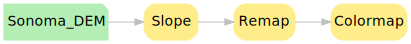

In [30]:
# Create slope index layer with a raster function chain
slope_index = colormap(remap(slope(dem),
                             input_ranges=[0,  5,  # Flat
                                           5, 15,  # Low
                                           15, 25,  # Moderate
                                           25, 35,  # Steep
                                           35, 91], # Very Steep
                             output_values=[1, 2, 3, 4, 5], 
                             astype='u8'),
                       colormap=[[1, 56, 168, 0], [2, 141, 212, 0], 
                                 [3, 255, 255, 0], [4, 255, 128, 0], 
                                 [5, 255, 0, 0]])

# Overview of what raster functions have been applied to 
# create slope_index layer
slope_index.draw_graph()

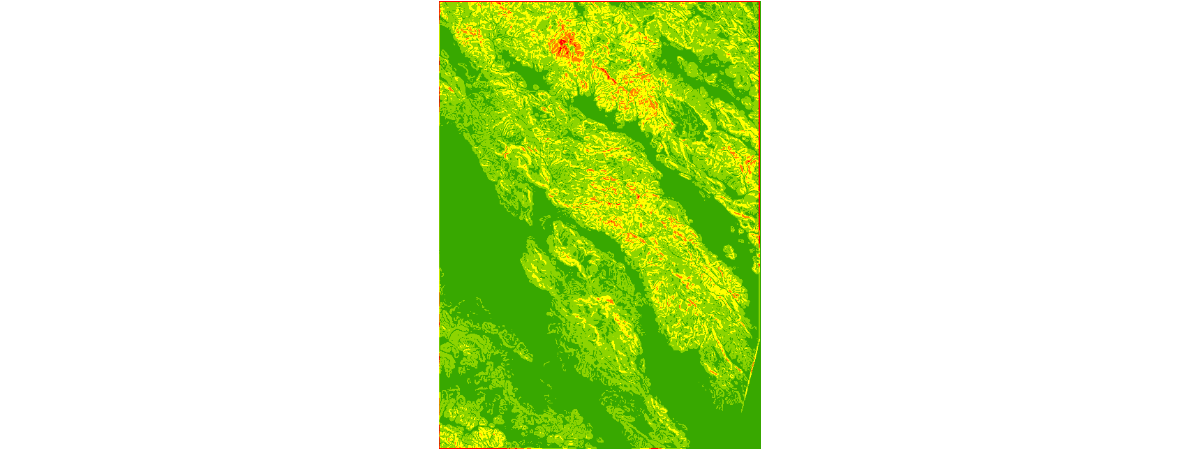

In [31]:
# Visualize slope index layer
slope_index

# Create the landslide risk map
The landslide risk calculation combines the two variables you just worked with: burn severity and slope. It also includes landcover, which is also important to landslide risk. Vegetation stabilizes slopes via root systems. Wildfire can wipe out much of the stabilizing vegetation. Some types of vegetation have adapted to wildfire, such as species of chaparral, which have root systems that are especially deep underground to survive fires.

In this section, we will first reclassify Landcover into five categories depending on its stabilizing effect on slopes. Then, we'll perform a Weighted Overlay Analysis based on the following three factors to determine the landslide risk in the study area:

 - Burn severity (less severely burned areas have lower landslide risk)
 - Slope (lower slope areas have lower landslide risk)
 - Stability index (higher vegetation-stablized areas have lower landslide risk)
The weighted overlay is a standard GIS analysis technique often used for solving multi-criteria problems such as generating surfaces representing site suitability and travel cost. Weighted overlay is used when a number of factors of varying importance should be considered to arrive at a final decision.

# Reclassify landcover type to reflect vegetation stabiilty

In [32]:
# Remap landcover to derive values for vegetation stability
stability_index = remap(nlcd,
                        input_ranges=[0,  12, 
                                      21, 23, 
                                      23, 23, 
                                      24, 31, 
                                      31, 44,
                                      52, 52,
                                      71, 71,
                                      81, 81,
                                      82, 82,
                                      90, 95], 
                        output_values=[1, 3, 4, 5, 1, 3, 4, 3, 4, 2], 
                        # 1: very stable 2: stable 3: moderate 
                        # 4: unstable 5: very unstable
                        astype='u8')

# Perform a weighted overlay analysis
Now that we have gathered the different layers required for the analysis, we can proceed with the weighted overlay analysis.

 - Step 1: Normalize the input datasets We have already used the remap function to normalize all the input datasets (burn_severity, slope_index, and stability_index) to a common scale of 1 - 5. Locations assigned the value of 1 are considered to carry the least landslide risk (e.g. stablized slopes with low burn severity), while locations assigned the value of 5 are considered to carry a high risk of landslide (e.g. the steepest slopes and most burned areas).

 - Step 2: Assign weights to the normalized input datasets based on their relative importance

In this step we assign "weights" to the normalized inputs by multiplying each of them by a value between 0.0 and 1.0. The sum of the weight values must equal 1.0

We'll use map algebra to apply the following weights to the criteria of this study:

     - Burn severity: 30%
     - Slope: 55%
     - Stability index: 15%
We'll multiply each raster in the step below to produce the final result.

 - Step 3: Calculate the sum of the weighted input datasets

In this step, we calculate the final result of the weighted overlay by calculating the sum of the weighted input datasets. Areas that are most likely to have landslides according to our multi-criteria based on burn severity, slope, and stability index are assigned a value of 5 and displayed in red. Areas that are least likely to have landslides are assigned a value of 1 and displayed in green.

In [33]:
landslide_risk = colormap(# burn severity
                         0.30 * burn_severity
                         + 
                         # Slope index
                         0.55 * slope_index
                         +
                         # Stability index
                         0.15 * stability_index,
                         colormap=[[1, 56, 168, 0], [2, 141, 212, 0], 
                                   [3, 255, 255, 0], [4, 255, 128, 0], 
                                   [5, 255, 0, 0]],
                         astype='u8')

In [34]:
# Create three maps to compare before and after imageries 
# and the landslide risk map side by side
map1 = gis.map(location='-122.58, 38.45', zoomlevel=15)
map2 = gis.map(location='-122.58, 38.45', zoomlevel=15)
map3 = gis.map(location='-122.58, 38.45', zoomlevel=15)
map1.layout = Layout(flex='1 1', height='500px', padding='5px')
map2.layout = Layout(flex='1 1', height='500px', padding='5px')
map3.layout = Layout(flex='1 1', height='500px', padding='5px')
map1.add_layer(infrared_before)
map2.add_layer(infrared_after)
map3.add_layer(landslide_risk)
box = HBox([map1, map2, map3])
box

Exception: Invalid or missing input parameters.
Operation on file C:\users\arcgis\Local Settings\Application Data\ESRI\Local Caches\MapCacheV1\pythonapi.playground.esri.com_server_services_after_l8_tif_imageserver?token=31ktespp9sedczsaokjmqvxp-ss3rtljzw7tq6upi0fxxiwqh_tj9ahmz6zemvrqs_vz5t7gwnzecowxx1uu-fzbzzjwmfiukqnqetxz2t4u0vdvzb_4ojikviocvptkeov2vr3jzt_fydhjqkmnzxklhxls4eak9t5li97hcqe. failed. Unknown error.
(Error Code: 400)

# Generate a persistent analysis result via Raster Analysis
Raster functions perform their calculations on-the-fly. Since no intermediate datasets are created, processes can be applied quickly, as opposed to the time it would take to create a processed file on disk.

ArcGIS Enterprise can perform distributed server-based processing on imagery and raster data. By using Raster Analysis on an ArcGIS Image Server federated with your ArcGIS Enterprise portal, you can generate persistent analysis results from raster functions using distributed processing.

This technology enables you to boost the performance of raster processing by processing data across multiple cores, even at full resolution and full extent. The results of this processing are accessed in a web imagery layer hosted in the ArcGIS Enterprise portal.

For more information, see Distributed raster analysis

To save the landslide risk layer as a persistent Imagery Layer on your GIS, call the save() method on the layer. This invokes the distributed raster processing, applies the chain of raster functions at full resolution, and serves the result as a new Imagery Layer.

In [ ]:
# Save the result as an image service
landslide_risk_persistent = landslide_risk.save("Sonoma_Landslide_Risk_KE")

In [25]:
# Share it to the public
landslide_risk_persistent.share(everyone=True, org=True)

NameError: name 'landslide_risk_persistent' is not defined

# Summarize landslide risk by sub-basin
Although the landslide risk map is useful, you may want to go further to break down the areas that are most at risk. Because landslide risk is impacted by precipitation patterns and watershed characteristics, we'll summarize risk by watershed basins within the study area. We’ll use the landslide risk map produced in the previous step to summarize risk per sub-basin.

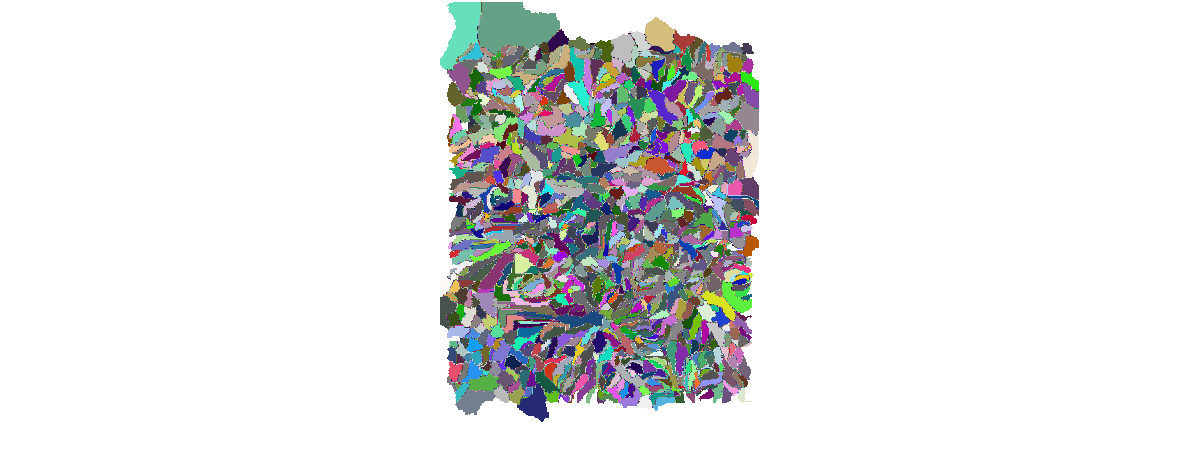

In [26]:
# Preview of the sub-basin layer
basins

Now we will use a global raster function called Zonal Statistics to calculates statistics on values of a raster within the zones of another dataset. You will need the following parameters:

 - in_zone_data: dataset that defines the zones
 - zone_field: Field that holds the values that define each zone
 - in_value_raster: Raster that contains the values on which to calculate a statistic
 - ignore_no_data: Denotes whether NoData values in the Value Raster will influence the results of the zone that they fall within.
 - statistics_type: The Statistic to be calculated. Can take any of the following values: MEAN, MAJORITY, MAXIMUM, MEDIAN, MINIMUM, MINORITY, RANGE, STD, SUM, VARIETY.
More information about this function can be found here Zonal Statistics Global Function.

In [27]:
%%time
# Run global raster function and generate a persistent result in portal
landslide_risk_per_basin = gbl.zonal_statistics(in_zone_data = basins, 
                                        zone_field='Value', 
                                        in_value_raster=landslide_risk, 
                                        ignore_nodata=True, 
                                        statistics_type='MEAN')

landslide_risk_per_basin_saved = landslide_risk_per_basin.save(
                                        "Landslide_Risk_Per_Basin_KE")

{"messageCode": "RA_120200", "message": "Underlying Geoprocessing tool failed."}
Traceback (most recent call last):
  File "Z:\arcgis\server\framework\runtime\ArcGIS\Resources\ArcToolBox\Services\Scripts\GenerateRaster.py", line 132, in <module>
    arcpy.AddMessage(inrft)
  File "z:\arcgis\server\framework\runtime\arcgis\Resources\arcpy\arcpy\management.py", line 19016, in GenerateRasterFromRasterFunction
    raise e
  File "z:\arcgis\server\framework\runtime\arcgis\Resources\arcpy\arcpy\management.py", line 19013, in GenerateRasterFromRasterFunction
    retval = convertArcObjectToPythonObject(gp.GenerateRasterFromRasterFunction_management(*gp_fixargs((raster_function, out_raster_dataset, raster_function_arguments, raster_properties, format, process_as_multidimensional), True)))
  File "z:\arcgis\server\framework\runtime\arcgis\Resources\arcpy\arcpy\geoprocessing\_base.py", line 512, in <lambda>
    return lambda *args: val(*gp_fixargs(args, True))
arcgisscripting.ExecuteError: ERROR 

Exception: Job failed.

In [28]:
# Save the final result as a web map
landslide_by_basin_map = gis.map('-122.58, 38.45', 10)

landslide_by_basin_map.add_layer(landslide_risk_per_basin_saved, 
                options={'title':'Landslide risk aggregated per basin'})
landslide_by_basin_map.add_layer(landslide_risk, 
                options={'title':'Landslide risk',
                         'visibility':False})
landslide_by_basin_map.add_layer(infrared_before,
                options={'title':'Pre fire satellite imagery',
                         'visibility':False})
landslide_by_basin_map.add_layer(infrared_after,
                options={'title':'Post fire satellite imagery',
                         'visibility':False})
landslide_by_basin_map.add_layer(dem,
                options={'title':'Elevation layer used to derive slope',
                         'visibility':False})
landslide_by_basin_map.add_layer(nlcd,
                options={'title':'National LandCover Dataset',
                         'visibility':False})
landslide_by_basin_map.add_layer(basins,
                options={'title':'Watershed basins',
                         'visibility':False})

landslide_by_basin_map.add_layer(infrared_after)
landslide_by_basin_map.save({'title':'Landslide risk map Kate Emmel',
                            'tags':['landslide','analysis','forest fire'],
                            'snippet':'Landslide risk map per basin.'})

NameError: name 'landslide_risk_per_basin_saved' is not defined

Thus we have saved a web map containing the landslide risk per basin, overall landslide risk predictions, and all other layers used to derive the output. This map can easily be shared with local emergency management agencies.

# Conclusion

In this notebook example, we used raster function chains to create a burn severity map, slope index map, and landcover index map. We then created a landslide risk map, and summarized risk by watershed sub-basin. We used Raster Functions to represent our model as Python functions, chained them together and rendered them on the fly. Finally, to save them as presistent results on the GIS, we used the power of distributed raster processing available on the Image Server and created output landslide risk Imagery Layers. The graphic below shows the entire chain of analysis we have performed so far.

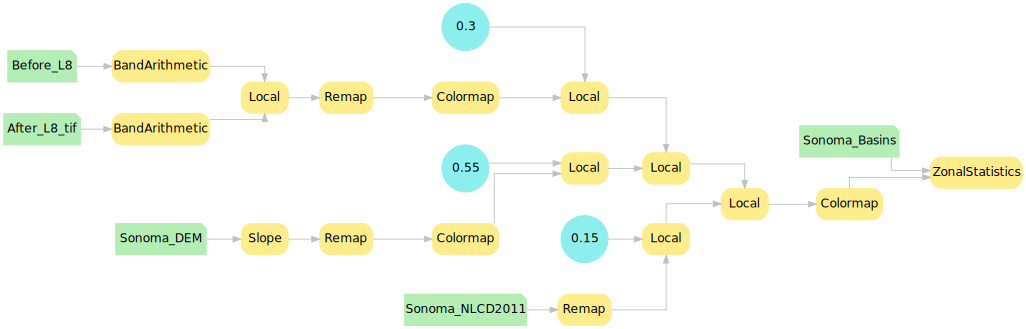

In [29]:
landslide_risk_per_basin.draw_graph()